<a href="https://colab.research.google.com/github/skhazaei/TensorFlow-repo/blob/master/imdb_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Check the version of tensorflow: 
if its version is 1.X, then runs `tf.enable_eager_excution()`

In [1]:
import tensorflow as tf
print(tf.__version__)

2.4.1


## Import imdb_reviews dataset from tensorflow-datasets

In [2]:
import tensorflow_datasets as tfds
#!pip install -q tensorflow-datasets

imdb, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete8BRI8B/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete8BRI8B/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete8BRI8B/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


## Split dataset to train and test sets

In [3]:
train_data, test_data = imdb['train'], imdb['test']

In [4]:
# check the format of train and test data
print(type(train_data))
print(type(test_data))

<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>


In [5]:
# Check how large is the train and test data
print(len(train_data))
print(len(test_data))

25000
25000


## Extract sentences and labels for train and test set

### `train_data` and `test_data` are iterable. Sentences and labels are tensors. By calling numpy method, their values are extracted.

In [6]:
training_sentences=[]
training_labels=[]

for s, l in train_data:
  training_sentences.append(s.numpy().decode('utf8'))
  training_labels.append(l.numpy())

In [37]:
test_sentences=[]
test_labels=[]

for s, l in test_data:
  test_sentences.append(s.numpy().decode('utf8'))
  test_labels.append(l.numpy())

In [38]:
print(training_sentences[0])
print(training_labels[0])

This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.
0


In [58]:
print(training_sentences[3])
print(training_labels[3])

This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful performances from Cher and Nicolas Cage (as always) gently row the plot along. There are no rapids to cross, no dangerous waters, just a warm and witty paddle through New York life at its best. A family film in every sense and one that deserves the praise it received.
1


## Convert the labels from list to the numpy array

In [40]:
import numpy as np

training_labels_final = np.array(training_labels)
test_labels_final = np.array(test_labels)

## Now let's tokenize the sentences

In [41]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Hyperparameters
vocab_size=10000
max_length = 120
embedding_dim = 16
trunc_type='post'
oov_tok = '<OOV>'

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)

# pad the sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)

## Let's do the same for the testing sequences

In [42]:
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, maxlen=max_length)

## Define two neural Network models, using `Flatten` and `GlobalAveragePooling1D`

In [43]:
model_1 = tf.keras.models.Sequential([tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
                                   tf.keras.layers.Flatten(),
                                   tf.keras.layers.Dense(6, activation=tf.nn.relu),
                                   tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)])
model_1.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
flatten_4 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 11526     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 7         
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


In [44]:
model_2 = tf.keras.models.Sequential([tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
                                      tf.keras.layers.GlobalAveragePooling1D(),
                                      tf.keras.layers.Dense(6, activation=tf.nn.relu),
                                      tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
                                      ])
model_2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 6)                 102       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 7         
Total params: 160,109
Trainable params: 160,109
Non-trainable params: 0
_________________________________________________________________


## Let's try first the **model** with `Flatten`

In [47]:
model = model_1
model.compile(optimizer=tf.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(padded, training_labels_final, epochs=10, validation_data=(test_padded, test_labels_final),verbose=2)

Epoch 1/10
782/782 - 5s - loss: 0.0479 - accuracy: 0.9904 - val_loss: 0.8288 - val_accuracy: 0.8138
Epoch 2/10
782/782 - 4s - loss: 0.0481 - accuracy: 0.9902 - val_loss: 0.9428 - val_accuracy: 0.8120
Epoch 3/10
782/782 - 4s - loss: 0.0455 - accuracy: 0.9910 - val_loss: 0.9048 - val_accuracy: 0.8131
Epoch 4/10
782/782 - 4s - loss: 0.0442 - accuracy: 0.9913 - val_loss: 0.8907 - val_accuracy: 0.8118
Epoch 5/10
782/782 - 4s - loss: 0.0440 - accuracy: 0.9913 - val_loss: 0.9055 - val_accuracy: 0.8120
Epoch 6/10
782/782 - 4s - loss: 0.0440 - accuracy: 0.9913 - val_loss: 0.9032 - val_accuracy: 0.8118
Epoch 7/10
782/782 - 4s - loss: 0.0438 - accuracy: 0.9914 - val_loss: 0.9201 - val_accuracy: 0.8124
Epoch 8/10
782/782 - 4s - loss: 0.0438 - accuracy: 0.9914 - val_loss: 0.9297 - val_accuracy: 0.8132
Epoch 9/10
782/782 - 4s - loss: 0.0438 - accuracy: 0.9914 - val_loss: 0.9279 - val_accuracy: 0.8128
Epoch 10/10
782/782 - 4s - loss: 0.0438 - accuracy: 0.9914 - val_loss: 0.9307 - val_accuracy: 0.8130

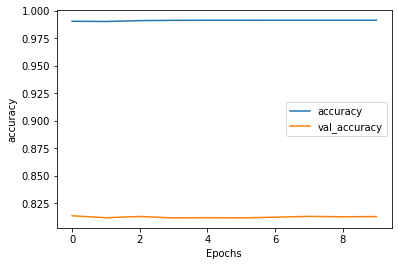

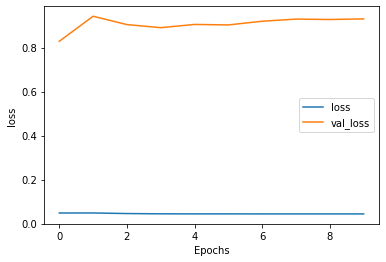

In [48]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Now let's try the model with `GlobalAveragePooling1D`

In [49]:
model = model_2
model.compile(optimizer=tf.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(padded, training_labels_final, epochs=10, validation_data=(test_padded, test_labels_final),verbose=2)

Epoch 1/10
782/782 - 5s - loss: 0.5441 - accuracy: 0.7578 - val_loss: 0.3792 - val_accuracy: 0.8455
Epoch 2/10
782/782 - 4s - loss: 0.3291 - accuracy: 0.8642 - val_loss: 0.3306 - val_accuracy: 0.8576
Epoch 3/10
782/782 - 4s - loss: 0.2670 - accuracy: 0.8927 - val_loss: 0.3311 - val_accuracy: 0.8572
Epoch 4/10
782/782 - 4s - loss: 0.2307 - accuracy: 0.9102 - val_loss: 0.3448 - val_accuracy: 0.8532
Epoch 5/10
782/782 - 4s - loss: 0.2043 - accuracy: 0.9240 - val_loss: 0.3687 - val_accuracy: 0.8476
Epoch 6/10
782/782 - 4s - loss: 0.1831 - accuracy: 0.9334 - val_loss: 0.3963 - val_accuracy: 0.8420
Epoch 7/10
782/782 - 4s - loss: 0.1659 - accuracy: 0.9397 - val_loss: 0.4326 - val_accuracy: 0.8354
Epoch 8/10
782/782 - 4s - loss: 0.1511 - accuracy: 0.9474 - val_loss: 0.4637 - val_accuracy: 0.8333
Epoch 9/10
782/782 - 4s - loss: 0.1378 - accuracy: 0.9537 - val_loss: 0.5041 - val_accuracy: 0.8294
Epoch 10/10
782/782 - 4s - loss: 0.1254 - accuracy: 0.9582 - val_loss: 0.5417 - val_accuracy: 0.8232

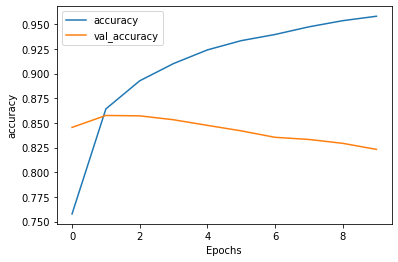

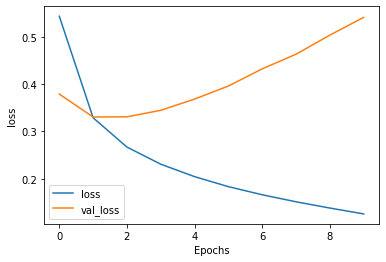

In [50]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Extract and visualizing embedding weights 

In [66]:
res = model.layers[0]
weights = res.get_weights()[0]
print('weight shape (vocab_size, embedding_dim): ', weights.shape)

weight shape (vocab_size, embedding_dim):  (10000, 16)


This means we have 10,000 words in our corpus and are working in a 16 dimensional array. 

The word index has the key being the word, and the value being the token for the word. We'll need to flip this around, to look through the padded list to decode the tokens back into the words, so we need a helper function:

In [67]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[2]))
print(training_sentences[2])

mann photographs the <OOV> rocky mountains in a superb fashion and jimmy stewart and walter brennan give enjoyable performances as they always seem to do br br but come on hollywood a <OOV> telling the people of dawson city <OOV> to <OOV> themselves a <OOV> yes a <OOV> and to <OOV> the law themselves then <OOV> battling it out on the streets for control of the town br br nothing even remotely resembling that happened on the canadian side of the border during the <OOV> gold rush mr mann and company appear to have mistaken dawson city for <OOV> the canadian north for the american wild west br br canadian viewers be prepared for a <OOV> madness type of enjoyable
Mann photographs the Alberta Rocky Mountains in a superb fashion, and Jimmy Stewart and Walter Brennan give enjoyable performances as they always seem to do. <br /><br />But come on Hollywood - a Mountie telling the people of Dawson City, Yukon to elect themselves a marshal (yes a marshal!) and to enforce the law themselves, then 

## Vectors and metadata auto files:

The TensorFlow Projector reads this file type and uses it to plot the vectors in 3D space so we can visualize them.

In [68]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [70]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Check the TensorFlow Embedding Projector on projector.tensorflow.org to visualize your results.